# Introduction

In this Jupyter Notebook we importing the ENTSO-E Actual Generation per Type data (processed with OPSD time series script) and correcting the hourly data with reported yearly values from ENTSO-E statistical factsheet.

The OPSD time series script converts all data to one resolution (1 hour) and interpolate gaps in the datat set with a max length of 2 hours. 

# Script setup

In [1]:
import numpy as np
import pandas as pd

#Helpers
import os
import glob
from datetime import datetime, date, timedelta, time


#Ploting
import matplotlib.pyplot as plt

%matplotlib inline
plt.style.use('seaborn')
plt.rcParams['figure.figsize'] = [15, 6]

# Data directory preparention

Create input, processed and output folders if they don't exist. If the paths are relative, the corresponding folders will be created inside the current working directory.
- input -> all needed input data
- processed -> save point and exchange with other scripts
- output -> final data

In [2]:
input_directory_path = os.path.join('input')
processed_directory_path = 'processed'
output_directory_path = os.path.join('output')

sources_yaml_path = os.path.join('input', 'sources.yml')

os.makedirs(input_directory_path, exist_ok=True)
os.makedirs(processed_directory_path, exist_ok=True)
os.makedirs(output_directory_path, exist_ok=True)

# Data file preparation

1. ENTSO-E Transparency Platform, Actual Generation per Type Available online: https://transparency.entsoe.eu/generation/r2/actualGenerationPerProductionType/show (accessed on Oct 02, 2020).
 - Proccesed with OPSD time series scrips (own version INETCH)
 time_series_60min_stacked.csv
 
2. ENTSO-E Statistical Factsheet 2018 in Comma Separated Value (CSV) format
https://zenodo.org/record/3461691


Original data: ENTSO-E statistics Available online:
https://www.entsoe.eu/publications/statistics-and-data/#statistical-factsheet

 File - > entsoe-statistical-factsheet-2018-stacked



Previously we used the Energy Balances in the MS Excel file format (2020 edition) eurostat https://ec.europa.eu/eurostat/de/web/energy/data/energy-balances (accessed on Oct 02, 2020). The Energy Balance data only provides gross electricity data.

# Load data functions

In [3]:
def load_timeseries_opsd(fn):
    """
    Read data from OPSD time-series package own modification.

    Parameters
    ----------
    years : None or slice()
        Years for which to read load data
        
    fn : file name or url location (file format .csv)
    
    countries : Countries for which to read load data.
        
    Returns
    -------
    load : pd.DataFrame
        Load time-series with UTC timestamps x ISO-2 countries
    """

     
    generation = pd.read_csv(fn, index_col='utc_timestamp', parse_dates=True) #, header=[0, 1, 2, 3, 4, 5], parse_dates=True)
                    #.dropna(how="all", axis=0)  
        
    #generation.columns = generation.columns.droplevel(level=[2,3,4,5])
    #generation = generation[~generation['region'].str.contains("_")]

    generation = generation.drop(columns='attribute')
    
    return generation

def load_stats_factsheet(path, fn):
    """
    Load the ENTSO-E Statistical Factsheet 2018 in Comma Separated Value (CSV).
        
    Parameters
    ----------
    path: str
        path to data
    fn : str
        filename
        
    """
    
    generation = pd.read_csv(os.path.join(path, fn),index_col=[0], header=[0, 1], parse_dates=True)
    
    return generation

def load_generation_per_unit(path, fn):
    """
    Load the ENTSO-E gernation per unit data.
        
    Parameters
    ----------
    path: str
        path to data
    fn : str
        filename
        
    """
    
    generation = pd.read_csv(os.path.join(path, fn),sep = ',',index_col=0,parse_dates=True)
    
    return generation

def load_unit_info(path, fn):
    """
    Load the ENTSO-E generation unit information.
        
    Parameters
    ----------
    path: str
        path to data
    fn : str
        filename
        
    """
    
    df = pd.read_csv(os.path.join(path, fn),sep = ',',index_col=0)
    
    
    # set name for the index
    df.index.set_names('GenerationUnitEIC', inplace=True)

    return df

In [4]:
def convert_ENTSOE_to_INATECH_type(ProductionTypeName):
    """
    Converts ENTSO-E Generation per Type source names into INATECH technology type names.

    Parameters
    ----------
    ProductionTypeName : string
        ENTSO-E name of production type.

    Returns
    -------
    string
        INATECH names of production type.

    """

    return ProductionTypeName.replace({
            'Fossil Hard coal': 'hard_coal', 
            'Fossil Brown coal/Lignite': 'lignite', 
            'Fossil Gas': 'gas',
            'Fossil Coal-derived gas': 'other_fossil',
            'Fossil Peat': 'other_fossil',
            'Nuclear': 'nuclear',
            'Biomass': 'biomass',
            'Waste': 'waste',
            'Geothermal': 'other_renewable',
            'Marine': 'other_renewable',
            'Other': 'other_fossil',
            'Hydro Pumped Storage': 'hydro',
            'Hydro Run-of-river and poundage': 'hydro',
            'Hydro Water Reservoir': 'hydro',
            'Fossil Oil': 'other_fossil',
            'Fossil Oil shale': 'other_fossil', 
            'Solar': 'solar',
            'Wind Onshore': 'wind_onshore',
            'Wind Offshore': 'wind_offshore',
            'Other renewable': 'other_renewable'}, inplace=False)

# Load and filter data¶

In [5]:
# period filter
start = '2018-01-01 00:00:00+00:00'
end = '2018-12-31 23:00:00+00:00'

## load data timeseries_opsd

In [6]:
# load data
entsoe_gen_type = load_timeseries_opsd(fn=input_directory_path + '/time_series_60min_stacked.csv')

In [7]:
entsoe_gen_type = entsoe_gen_type.loc[start:end].copy()

In [8]:
# show the data set
entsoe_gen_type

,region,variable,data
utc_timestamp,,,
2018-01-01 00:00:00+00:00,AT,Biomass,316.0
2018-01-01 01:00:00+00:00,AT,Biomass,316.0
2018-01-01 02:00:00+00:00,AT,Biomass,316.0
2018-01-01 03:00:00+00:00,AT,Biomass,316.0
2018-01-01 04:00:00+00:00,AT,Biomass,316.0
...,...,...,...
2018-12-31 19:00:00+00:00,SK,Solar,0.4
2018-12-31 20:00:00+00:00,SK,Solar,0.2
2018-12-31 21:00:00+00:00,SK,Solar,0.2


## load and standardize data Stats FACT

In [9]:
# load data
entsoe_stats = load_stats_factsheet(input_directory_path, 'Stats_FACT_table.csv')

In [10]:
# show the data set
entsoe_stats

country         AL                                                         \
source     biomass  gas hard_coal      hydro lignite nuclear other_fossil   
year                                                                        
2018-01-01     0.0  0.0       0.0  8100000.0     0.0     0.0          0.0   

country                                 ...          TR              \
source     other_renewable solar waste  ...   hard_coal       hydro   
year                                    ...                           
2018-01-01             0.0   0.0   0.0  ...  67800000.0  59800000.0   

country                                                                       \
source         lignite nuclear other_fossil other_renewable      solar waste   
year                                                                           
2018-01-01  44800000.0     0.0    1400000.0       6900000.0  7200000.0   0.0   

country                                
source     wind_offshore wind_onshore  
year                                   
2018-01-01           0.0   19900000.0  

[1 rows x 432 columns]

## standardize data

In [11]:
# available countries in entsoe stats data set
countries = entsoe_stats.columns.levels[0].to_list()

In [12]:
countries

['AL',
 'AT',
 'BA',
 'BE',
 'BG',
 'CH',
 'CY',
 'CZ',
 'DE',
 'DK',
 'EE',
 'ES',
 'FI',
 'FR',
 'GB',
 'GR',
 'HR',
 'HU',
 'IE',
 'IS',
 'IT',
 'LT',
 'LU',
 'LV',
 'ME',
 'MK',
 'NL',
 'NO',
 'PL',
 'PT',
 'RO',
 'RS',
 'SE',
 'SI',
 'SK',
 'TR']

In [13]:
entsoe_gen_type.region.unique()

array(['AT', 'BE', 'BG', 'CH', 'CY', 'CZ', 'DE', 'DE_50hertz', 'DE_LU',
       'DE_amprion', 'DE_tennet', 'DE_transnetbw', 'DK', 'DK_1', 'DK_2',
       'DK_energinet', 'EE', 'ES', 'FI', 'FR', 'GB_GBN', 'GB_NIR',
       'GB_UKM', 'GR', 'HU', 'IE', 'IE_sem', 'IT', 'IT_BRNN', 'IT_CNOR',
       'IT_CSUD', 'IT_FOGN', 'IT_NORD', 'IT_PRGP', 'IT_ROSN', 'IT_SARD',
       'IT_SICI', 'IT_SUD', 'LT', 'LV', 'ME', 'NL', 'NO', 'NO_1', 'NO_2',
       'NO_3', 'NO_4', 'NO_5', 'PL', 'PT', 'RO', 'RS', 'SE', 'SE_1',
       'SE_2', 'SE_3', 'SE_4', 'SI', 'SK'], dtype=object)

In [14]:
# replace region GB_UKM with GB
entsoe_gen_type.region = entsoe_gen_type.region.replace({'GB_UKM' : 'GB'})

In [15]:
# filter entso e data
entsoe_gen_type.query('region in @countries', inplace= True)

In [16]:
entsoe_gen_type.variable.unique()

array(['Biomass', 'Fossil Gas', 'Fossil Hard coal', 'Geothermal',
       'Hydro Pumped Storage', 'Hydro Run-of-river and poundage',
       'Hydro Water Reservoir', 'Other', 'Solar', 'Waste', 'Wind Onshore',
       'Fossil Oil', 'Nuclear', 'Wind Offshore',
       'Fossil Brown coal/Lignite', 'Fossil Coal-derived gas',
       'Other renewable', 'Fossil Peat'], dtype=object)

In [17]:
# change ProductionTypeNames into INATECH technology type names
entsoe_gen_type.variable = convert_ENTSOE_to_INATECH_type(entsoe_gen_type.variable)

In [18]:
entsoe_gen_type.variable.unique()

array(['biomass', 'gas', 'hard_coal', 'other_renewable', 'hydro',
       'other_fossil', 'solar', 'waste', 'wind_onshore', 'nuclear',
       'wind_offshore', 'lignite'], dtype=object)

In [19]:
# after changing the production type we need to group the dataset
# reset index for groupby function
entsoe_gen_type.reset_index(inplace=True)
# group same production types
entsoe_gen_type = entsoe_gen_type.groupby(['variable', 'utc_timestamp','region']).sum()
# set the old index for the dataframe
entsoe_gen_type = entsoe_gen_type.reset_index().set_index('utc_timestamp')

In [20]:
# show the head of the data set 
entsoe_gen_type.head(10)

,variable,region,data
utc_timestamp,,,
2018-01-01 00:00:00+00:00,biomass,AT,316.00
2018-01-01 00:00:00+00:00,biomass,BE,232.46
2018-01-01 00:00:00+00:00,biomass,BG,28.00
2018-01-01 00:00:00+00:00,biomass,CZ,261.78
2018-01-01 00:00:00+00:00,biomass,DE,4764.00
2018-01-01 00:00:00+00:00,biomass,DK,587.00
2018-01-01 00:00:00+00:00,biomass,EE,71.10
2018-01-01 00:00:00+00:00,biomass,ES,275.00
2018-01-01 00:00:00+00:00,biomass,FI,855.71


In [21]:
# convert entso data into table format
entsoe_gen_type_table =  pd.pivot_table(entsoe_gen_type, values='data', index=entsoe_gen_type.index, columns=['region','variable'])

In [22]:
entsoe_gen_type_table.head()

region                         AT                                       \
variable                  biomass   gas hard_coal   hydro other_fossil   
utc_timestamp                                                            
2018-01-01 00:00:00+00:00   316.0  71.0     150.0  3345.0         22.0   
2018-01-01 01:00:00+00:00   316.0  70.0     149.0  3275.0         22.0   
2018-01-01 02:00:00+00:00   316.0  69.0     149.0  3167.0         22.0   
2018-01-01 03:00:00+00:00   316.0  72.0     149.0  3160.0         22.0   
2018-01-01 04:00:00+00:00   316.0  75.0     149.0  3330.0         22.0   

region                                                                   BE  \
variable                  other_renewable solar  waste wind_onshore biomass   
utc_timestamp                                                                 
2018-01-01 00:00:00+00:00             0.0   0.0  100.0        832.0  232.46   
2018-01-01 01:00:00+00:00             0.0   0.0  100.0        926.0  153.58   
2018-01-01 02:00:00+00:00             0.0   0.0  100.0        692.0  133.70   
2018-01-01 03:00:00+00:00             0.0   0.0  100.0        453.0  131.38   
2018-01-01 04:00:00+00:00             0.0   0.0  100.0        321.0  131.26   

region                     ...           SI      SK                           \
variable                   ... wind_onshore biomass    gas hard_coal   hydro   
utc_timestamp              ...                                                 
2018-01-01 00:00:00+00:00  ...         0.70    28.2  175.6      48.1  455.93   
2018-01-01 01:00:00+00:00  ...         0.61    28.1  172.9      48.0  461.95   
2018-01-01 02:00:00+00:00  ...         0.57    28.1  162.1      46.7  513.39   
2018-01-01 03:00:00+00:00  ...         0.62    29.7  140.3      45.3  587.83   
2018-01-01 04:00:00+00:00  ...         0.56    29.5  143.5      46.4  562.89   

region                                                                        
variable                  lignite nuclear other_fossil other_renewable solar  
utc_timestamp                                                                 
2018-01-01 00:00:00+00:00   179.5  1819.3        478.8            41.4   0.0  
2018-01-01 01:00:00+00:00   177.9  1816.7        475.8            41.0   0.0  
2018-01-01 02:00:00+00:00   174.7  1808.7        469.5            40.8   0.0  
2018-01-01 03:00:00+00:00   168.5  1803.6        455.6            39.4   0.0  
2018-01-01 04:00:00+00:00   170.6  1809.1        461.5            40.4   0.0  

[5 rows x 214 columns]

## Check entsoe generation data for nan

In [23]:
def consecutive_nans(ds):
    return (ds.isnull().astype(int)
            .groupby(ds.notnull().astype(int).cumsum()[ds.isnull()])
            .transform('sum').fillna(0))

def nan_statistics(df):
    def max_consecutive_nans(ds):
        return (ds.isnull().astype(int)
                  .groupby(ds.notnull().astype(int).cumsum())
                  .sum().max())
    consecutive = df.apply(max_consecutive_nans)
    total = df.isnull().sum()
    max_total_per_month = df.isnull().resample('m').sum().max()
    return pd.concat([total, consecutive, max_total_per_month],
                 keys=['total', 'consecutive', 'max_total_per_month'], axis=1)

def change_multiindex(df):
    df = df.copy(deep=True)
    if df.columns.nlevels > 1:
        df.columns = [' '.join(col).strip() for col in df.columns.values]
    else:
        pass
    
    return df
    

In [24]:
# nan statistic for generation data
nan_statistic = nan_statistics(change_multiindex(entsoe_gen_type_table))

In [25]:
nan_statistic

,total,consecutive,max_total_per_month
AT biomass,0,0,0
AT gas,0,0,0
AT hard_coal,2952,2952,744
AT hydro,0,0,0
AT other_fossil,0,0,0
...,...,...,...
SK lignite,69,21,21
SK nuclear,69,21,21
SK other_fossil,69,21,21
SK other_renewable,69,21,21


In [26]:
# export statistic to csv file
nan_statistic.to_csv(output_directory_path + '/nan_statistic.csv')

## Manual adjustment of entsoe generation data 

We using some external sources to adjust the hourly production data for some countries.

- 1) ENTSO-E production per unit

Production per Unit from ENTSO-E
Original data: ENTSO-E Transparency Platform, Actual Generation per Generation Unit Available online: https://transparency.entsoe.eu/generation/r2/actualGenerationPerGenerationUnit/show (accessed on Apr 29, 2020).
Processed with the following script that converts the data to hourly resolution:

- https://github.com/INATECH-CIG/entso-e_GenerationOutputPerUnit

### Load power plant unit generation and inforamtion (capacity, name, etc.)

In [27]:
generation_per_unit_2018 = load_generation_per_unit(input_directory_path, 'gen_data_2018.csv')
generation_unit_info = load_unit_info(input_directory_path, 'unit_data_2018.csv')

In [28]:
# set same index for both dataframes
generation_per_unit_2018 = generation_per_unit_2018.set_index(entsoe_gen_type_table.index)

### Sweden

Overview of Swedisch genertaion units in ENTSO-E generation per unit.

In [29]:
generation_unit_info[(generation_unit_info.MapCode == 'SE')]

,AreaCode,AreaName,AreaTypeCode,InstalledGenCapacity,MapCode,PowerSystemResourceName,ProductionTypeName,ProductionUnitEIC,duplicate_count
GenerationUnitEIC,,,,,,,,,
46WGU00000000305,10YSE-1--------K,SvK CA,CTA,150.0,SE,Messaure G1,hydro,46WPU0000000032W,1.0
46WGU0000000034Y,10YSE-1--------K,SvK CA,CTA,225.0,SE,Seitevare G1,hydro,46WPU0000000033U,1.0
46WGU0000000045T,10YSE-1--------K,SvK CA,CTA,171.0,SE,Stornorrfors G4,hydro,46WPU0000000042T,1.0
46WGU0000000044V,10YSE-1--------K,SvK CA,CTA,136.0,SE,Stornorrfors G3,hydro,46WPU0000000042T,1.0
46WGU0000000137O,10YSE-1--------K,SvK CA,CTA,492.0,SE,Forsmark block 1 G11,nuclear,46WPU0000000015W,2.0
46WGU0000000017Y,10YSE-1--------K,SvK CA,CTA,0.0,SE,Karlshamn G1,other_fossil,46WPU0000000005Z,1.0
46WGU00000000208,10YSE-1--------K,SvK CA,CTA,320.0,SE,Ritsem G1,hydro,46WPU0000000026R,1.0
46WGU0000000026X,10YSE-1--------K,SvK CA,CTA,110.0,SE,Harsprånget G2,hydro,46WPU0000000029L,1.0
46WGU0000000027V,10YSE-1--------K,SvK CA,CTA,170.0,SE,Harsprånget G4,hydro,46WPU0000000029L,1.0


In [30]:
# sum of production per type in ENTSO-E per type data for 2018
print(entsoe_gen_type_table['SE'].sum())
print('total: ' + str(entsoe_gen_type_table['SE'].sum().sum()))

variable
hydro           62110097.0
nuclear         65787278.5
other_fossil     8334512.5
wind_onshore    16305413.0
dtype: float64
total: 152537301.0


In [31]:
# sum of production per type in ENTSO-E fact sheet for 2018
print(entsoe_stats['SE'].sum())
print('total: ' + str(entsoe_stats['SE'].sum().sum()))

source
biomass             9800000.0
gas                  600000.0
hard_coal            500000.0
hydro              61000000.0
lignite                   0.0
nuclear            65800000.0
other_fossil        1700000.0
other_renewable     1300000.0
solar                     0.0
waste                900000.0
wind_offshore             0.0
wind_onshore       16600000.0
dtype: float64
total: 158200000.0


If we compare both data sets, we can see that per type generation has less generation technologies than the ENTSO-E fact sheet. But the total generation of both data set is similar. We assume that the generation from missing technologies are incorrectly assigned in the per type generation data.
To corrode this we assume:
1. That the generation of biomass (9800 GWh from fact sheet) is assigned to the tech type "other_fossil" in the generation per type
2. That gas generation (600 GWh from fact sheet) is missing in the generation per type data
3. That hard coal generation (500 GWh from fact sheet) is missing in the generation per type data
4. That other_renewable (1300 GWH from fact sheet) is missing in the generation per type data
5. That other_fossil (1700 GWH from fact sheet) is not correctly represented because about wrong assignment with biomass
6. That waste (900 GWh from fact sheet) is missing in the generation per type data

Correction steps:

In [32]:
# 1. With the use of two biomass power plant generation series from ENTSO-E per unit generation and 90% of the other_fossil generation from ENTSO-E per type we build biomass generation. 
index = generation_unit_info[(generation_unit_info.MapCode == 'SE') & (generation_unit_info.ProductionTypeName == 'biomass')].index

entsoe_gen_type_table['SE', 'biomass'] = (generation_per_unit_2018[index].sum(axis=1) + (entsoe_gen_type_table['SE', 'other_fossil'] * 0.9)).copy()

In [33]:
# 2. With the use of one gas power plant generation series from ENTSO-E per unit generation we build gas generation.
index = generation_unit_info[(generation_unit_info.MapCode == 'SE') & (generation_unit_info.ProductionTypeName == 'gas')].index

entsoe_gen_type_table['SE', 'gas'] = generation_per_unit_2018[index].sum(axis=1).copy()

In [34]:
# 3. With the use of one hard_coal power plant generation series from ENTSO-E per unit generation we build hard_coal generation.
index = generation_unit_info[(generation_unit_info.MapCode == 'SE') & (generation_unit_info.ProductionTypeName == 'hard_coal')].index

entsoe_gen_type_table['SE', 'hard_coal'] = generation_per_unit_2018[index].sum(axis=1).copy()

In [35]:
# 4. Other_renewable is missing in all hourly dataset. By using the same generation profile as other_fossil (10%) and later scaling to the value of the fact sheet.
entsoe_gen_type_table['SE', 'other_renewable'] = (entsoe_gen_type_table['SE', 'other_fossil'] * 0.1).copy()

In [36]:
# 5. With the use of 8 other_fossil power plant generation series from ENTSO-E per unit generation and 10% of the other_fossil generation from ENTSO-E per type we build other_foosil generation.
index = generation_unit_info[(generation_unit_info.MapCode == 'SE') & (generation_unit_info.ProductionTypeName == 'other_fossil')].index

entsoe_gen_type_table['SE', 'other_fossil'] = (generation_per_unit_2018[index].sum(axis=1) + (entsoe_gen_type_table['SE', 'other_fossil'] * 0.1)).copy()

In [37]:
# 6. With the use of 10% of the other_fossil generation from ENTSO-E per type we build waste generation.
entsoe_gen_type_table['SE', 'waste'] = (entsoe_gen_type_table['SE', 'other_fossil'] * 0.1).copy()

In [38]:
# sum of production per type in ENTSO-E per type data for 2018
print(entsoe_gen_type_table['SE'].sum())
print('total: ' + str(entsoe_gen_type_table['SE'].sum().sum()))

variable
hydro              6.211010e+07
nuclear            6.578728e+07
other_fossil       1.022170e+06
wind_onshore       1.630541e+07
biomass            8.116121e+06
gas                4.082863e+05
hard_coal          3.784609e+05
other_renewable    8.334513e+05
waste              1.022170e+05
dtype: float64
total: 155063494.205


In [39]:
# sum of production per type in ENTSO-E fact sheet for 2018
print(entsoe_stats['SE'].sum())
print('total: ' + str(entsoe_stats['SE'].sum().sum()))

source
biomass             9800000.0
gas                  600000.0
hard_coal            500000.0
hydro              61000000.0
lignite                   0.0
nuclear            65800000.0
other_fossil        1700000.0
other_renewable     1300000.0
solar                     0.0
waste                900000.0
wind_offshore             0.0
wind_onshore       16600000.0
dtype: float64
total: 158200000.0


In [40]:
entsoe_gen_type_table['SE'].sum()

variable
hydro              6.211010e+07
nuclear            6.578728e+07
other_fossil       1.022170e+06
wind_onshore       1.630541e+07
biomass            8.116121e+06
gas                4.082863e+05
hard_coal          3.784609e+05
other_renewable    8.334513e+05
waste              1.022170e+05
dtype: float64

## Scaling entsoe generation data

In [41]:
# zwei Möglichkeiten zu skalieren
#1 skaliere nur, wenn der Wert in Quelle größer 0 ist und größer als im zu skalierenden Datensatz ist. Sonst überspringe und skaliere nicht.
#2 skaliere alles nach FACT Sheet
scaling_option = 1

In [42]:
# replace all nan with 0
entsoe_gen_type_table.fillna(0, inplace=True)

In [43]:
countries = entsoe_gen_type_table.columns.levels[0].to_list()

In [44]:
def normed(x): return x.divide(x.sum())

if scaling_option == 1:  

    entso_scaled = entsoe_gen_type_table.copy()

    for country in countries:
        for i in entso_scaled[country]:
            try:
                if entsoe_stats[country].at['2018',i] == 0:
                    pass
                    print(country + ' ' + i + ' stats = 0')
                elif entso_scaled[(country,i)].sum() == 0:
                    pass
                    print(country + ' ' + i + ' entso-e = 0; scaling not possible')
                elif entsoe_stats[country].at['2018',i] < entso_scaled[(country,i)].sum(): 
                    pass
                    print(country + ' ' + i + ' entso-e is >')
                else:
                    entso_scaled[(country,i)] = normed(entso_scaled[(country,i)]) * entsoe_stats[country].at['2018',i]
            except KeyError:
                pass
                print(country + ' ' + i + ' KeyError')

elif scaling_option == 2:

    entso_scaled = entsoe_gen_type_table.copy()
    
    for country in countries:
        for i in entso_scaled[country]:
            if entsoe_stats[country].at['2018',i] == 0:
                pass
                print(country + ' ' +i)
            else:
                try:
                    entso_scaled[(country,i)] = normed(entso_scaled[(country,i)]) * entsoe_stats[country].at['2018',i]
                except KeyError:
                    pass
                    print(country + ' ' +i)

else:                    
    pass
    print('Select one of the available scaling options')

AT biomass stats = 0
AT other_renewable entso-e = 0; scaling not possible
AT solar stats = 0
AT waste stats = 0
AT wind_onshore entso-e is >
BE gas entso-e is >
BE nuclear entso-e is >
BE other_fossil entso-e is >
BE solar entso-e is >
BE waste entso-e is >
BG gas entso-e is >
BG hard_coal entso-e is >
BG lignite entso-e is >
BG nuclear entso-e is >
BG waste stats = 0
CH nuclear entso-e is >
CY wind_onshore entso-e is >
CZ hard_coal entso-e is >
CZ hydro entso-e is >
CZ other_fossil entso-e is >
CZ other_renewable stats = 0
CZ solar entso-e is >
CZ waste stats = 0
CZ wind_onshore entso-e is >
DE biomass entso-e is >
DE hydro entso-e is >
DE other_fossil entso-e is >
DE solar entso-e is >
DE wind_offshore entso-e is >
DE wind_onshore entso-e is >
DK biomass entso-e is >
DK gas entso-e is >
DK other_fossil entso-e is >
DK waste stats = 0
DK wind_onshore entso-e is >
EE gas stats = 0
EE other_renewable stats = 0
EE solar stats = 0
EE waste stats = 0
EE wind_onshore entso-e is >
ES hard_co

## Check scaling

In [45]:
country = 'SE'

In [46]:
entsoe_gen_type_table[country].sum()

variable
hydro              6.211010e+07
nuclear            6.578728e+07
other_fossil       1.022170e+06
wind_onshore       1.630541e+07
biomass            8.116121e+06
gas                4.082863e+05
hard_coal          3.784609e+05
other_renewable    8.334513e+05
waste              1.022170e+05
dtype: float64

In [47]:
entsoe_gen_type_table[country].sum().sum()

155063494.205

In [48]:
entso_scaled[country].sum()

variable
hydro              62110097.0
nuclear            65800000.0
other_fossil        1700000.0
wind_onshore       16600000.0
biomass             9800000.0
gas                  600000.0
hard_coal            500000.0
other_renewable     1300000.0
waste                900000.0
dtype: float64

In [49]:
entso_scaled[country].sum().sum()

159310097.0

In [50]:
entsoe_stats[country].sum()

source
biomass             9800000.0
gas                  600000.0
hard_coal            500000.0
hydro              61000000.0
lignite                   0.0
nuclear            65800000.0
other_fossil        1700000.0
other_renewable     1300000.0
solar                     0.0
waste                900000.0
wind_offshore             0.0
wind_onshore       16600000.0
dtype: float64

In [51]:
entsoe_stats[country].sum().sum()

158200000.0

In [52]:
entsoe_stats[country].sum().sum() - entso_scaled[country].sum().sum()

-1110097.0

In [53]:
GE_compar = pd.DataFrame()

In [54]:
GE_compar.columns

Index([], dtype='object')

In [55]:
GE_compar = entsoe_gen_type_table.sum().reset_index().groupby('region').sum()

In [56]:
GE_compar['ENTSO_E_Generation_scaled'] = entso_scaled.sum().reset_index().groupby('region').sum()

In [57]:
GE_compar['diff'] = GE_compar['ENTSO_E_Generation_scaled'] - GE_compar[0]
GE_compar['diff_pro'] = (100 / GE_compar[0]) * GE_compar['diff']

#CI_compar['diff_bottom_up_vs_CI_1_top_down'] = CI_compar['CI_bottom_up'] - CI_compar['CI_1_top_down']
#CI_compar['diff_pro_1'] = round((100 / CI_compar['CI_bottom_up']) * CI_compar['diff_bottom_up_vs_CI_1_top_down'])

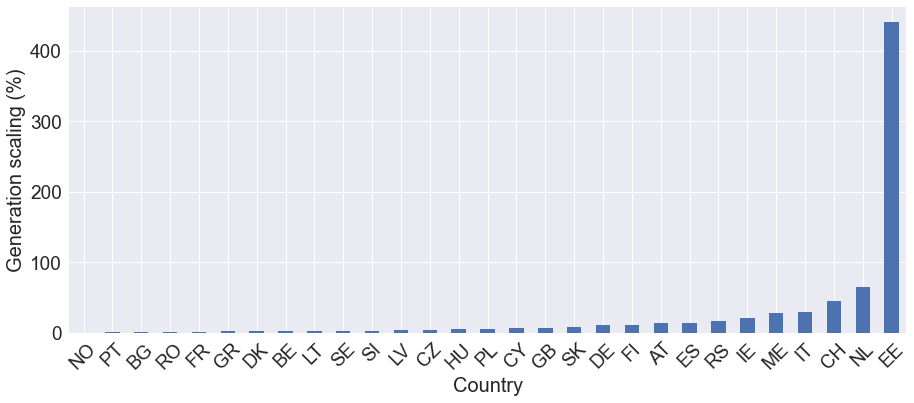

In [58]:
fig, ax = plt.subplots(1, 1)

ax = round(GE_compar, 2).sort_values(by='diff_pro')['diff_pro'].plot(kind='bar', ylabel='Generation scaling (%)')

ax.set_xlabel("Country" , fontsize=20)
ax.set_ylabel("Generation scaling (%)", fontsize=20)

ax.tick_params(axis='y',labelsize=19)
ax.tick_params(axis='x',labelsize=19)


ax.tick_params(axis='x', rotation=45)

In [59]:
fig.savefig(os.path.join(output_directory_path + '/_generation_scaling.png'))

(0.0, 80.0)

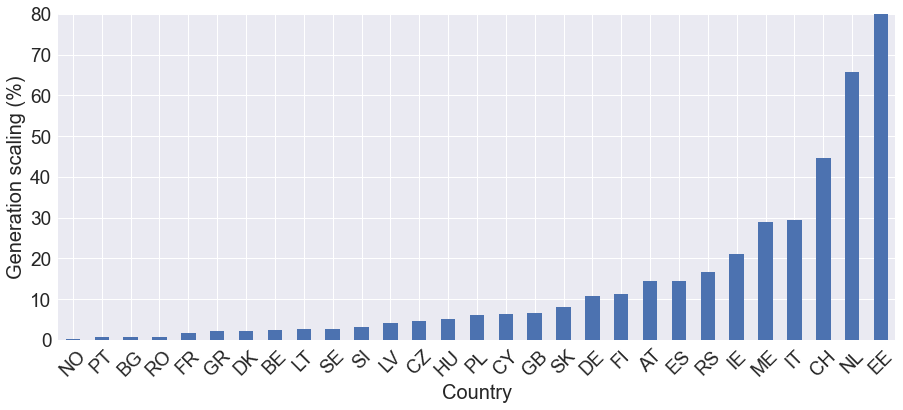

In [60]:
fig, ax = plt.subplots(1, 1)

ax = round(GE_compar, 2).sort_values(by='diff_pro')['diff_pro'].plot(kind='bar', ylabel='Generation scaling (%)')

ax.set_xlabel("Country" , fontsize=20)
ax.set_ylabel("Generation scaling (%)", fontsize=20)

ax.tick_params(axis='y',labelsize=19)
ax.tick_params(axis='x',labelsize=19)


ax.tick_params(axis='x', rotation=45)

# zoom-in / limit the view to different portions of the data
ax.set_ylim(0, 80)  # most of the data

In [61]:
fig.savefig(os.path.join(output_directory_path + '/_generation_scaling_zoom.png'))

# Export datasets

In [62]:
entsoe_gen_type.to_csv(output_directory_path + '/entsoe_gen_type_hourly.csv')

In [63]:
entsoe_gen_type_table.to_csv(output_directory_path + '/entsoe_gen_type_hourly_table.csv')

In [64]:
entso_scaled.to_csv(output_directory_path + '/entsoe_gen_type_hourly_table_scaled.csv')

# Export tech Dic

In [65]:
dic = {
            'Fossil Hard coal': 'hard_coal', 
            'Fossil Brown coal/Lignite': 'lignite', 
            'Fossil Gas': 'gas',
            'Fossil Coal-derived gas': 'other_fossil',
            'Fossil Peat': 'other_fossil',
            'Nuclear': 'nuclear',
            'Biomass': 'biomass',
            'Waste': 'waste',
            'Geothermal': 'other_renewable',
            'Marine': 'other_renewable',
            'Other': 'other_fossil',
            'Hydro Pumped Storage': 'hydro',
            'Hydro Run-of-river and poundage': 'hydro',
            'Hydro Water Reservoir': 'hydro',
            'Fossil Oil': 'other_fossil',
            'Fossil Oil shale': 'other_fossil', 
            'Solar': 'solar',
            'Wind Onshore': 'wind_onshore',
            'Wind Offshore': 'wind_offshore',
            'Other renewable': 'other_renewable'}

In [66]:
pd.DataFrame.from_dict(dic, columns=['B'], orient='index').to_csv(output_directory_path + '/entso_gen_type_dic.csv')